In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py

import tensorflow as tf
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from msfm import grid_pipeline
from msfm.utils import input_output, survey, maps

2023-02-20 13:33:18.452403: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cluster/apps/gcc-8.2.0/hdf5-1.10.1-qj3ju3qfhvucsk5eevrtb2lehbux5nmv/lib:/cluster/apps/gcc-8.2.0/r-4.2.2-ydfaklhfrhw5dy6qcfzxlxfviwovcord/rlib/R/lib:/cluster/apps/gcc-8.2.0/npm-6.14.9-774crfohwvu6a33ijcow7x5cvonu44oi/lib:/cluster/apps/gcc-8.2.0/openblas-0.3.15-huwxbhezdzoo74awrgoz6sd2qndpmdva/lib:/cluster/apps/nss/gcc-8.2.0/python/3.10.4/x86_64/lib64:/cluster/spack/apps/linux-centos7-x86_64/gcc-4.8.5/gcc-8.2.0-6xqov2fhvbmehix42slain67vprec3fs/lib64:/cluster/spack/apps/linux-centos7-x86_64/gcc-4.8.5/gcc-8.2.0-6xqov2fhvbmehix42slain67vprec3fs/lib:/cluster/apps/lsf/10.1/linux2.6-glibc2.3-x86_64/lib::
2023-02-20 13:33:18.452440: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on you

In [3]:
conf_dir = "../../configs/config.yaml"
conf = input_output.read_yaml(conf_dir)

repo_dir = "/cluster/home/athomsen/py3_10/repos/multiprobe-simulation-forward-model"
tfr_pattern = "/cluster/work/refregier/athomsen/CosmoGrid/DESY3/v2/DESy3_grid_???.tfrecord"

# for metacal
n_z_bins = 4
# corresponds to one cosmology as there are 4 sims per cosmology and 4 patches per full sky map
batch_size = 16

# these are not optimized for performance
examples_shuffle_buffer = 10
n_readers = 1
n_prefetch = 3

In [4]:
dset = grid_pipeline.get_grid_dset(conf, repo_dir, tfr_pattern, batch_size, i_noise=0, n_readers=n_readers, n_prefetch=n_prefetch)

23-02-20 13:33:28 grid_pipelin INF   Starting to generate the grid data set for i_noise = 0 
23-02-20 13:33:28    survey.py INF   Loaded pixel file 
23-02-20 13:33:28    survey.py INF   Loaded pixel file 


2023-02-20 13:33:28.815800: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-20 13:33:28.815874: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (eu-g5-001-3): /proc/driver/nvidia/version does not exist
2023-02-20 13:33:28.816719: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
23-02-20 13:33:30 grid_pipelin WAR   Tracing dset_add_bias 
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
23-02-20 13:33:32 grid_pipelin WAR   Tracing dset_add_noise 
23-02-20 13:33:32 grid_pipelin INF   Successfully generated the fiducial training set with element_spec (TensorSpec(shape=(None, 463872, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), (TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))) for i_noise = 0 


In [5]:
for kg, cosmo, index in dset.take(1):
    print(kg.shape, cosmo.shape, len(index))

(16, 463872, 4) (16, 7) 2


# plotting

In [6]:
data_vec_pix, _, _, tomo_patches_pix, tomo_corresponding_pix = survey.load_pixel_file(conf, repo_dir)
n_pix = conf["analysis"]["n_pix"]

23-02-20 13:33:33    survey.py INF   Loaded pixel file 


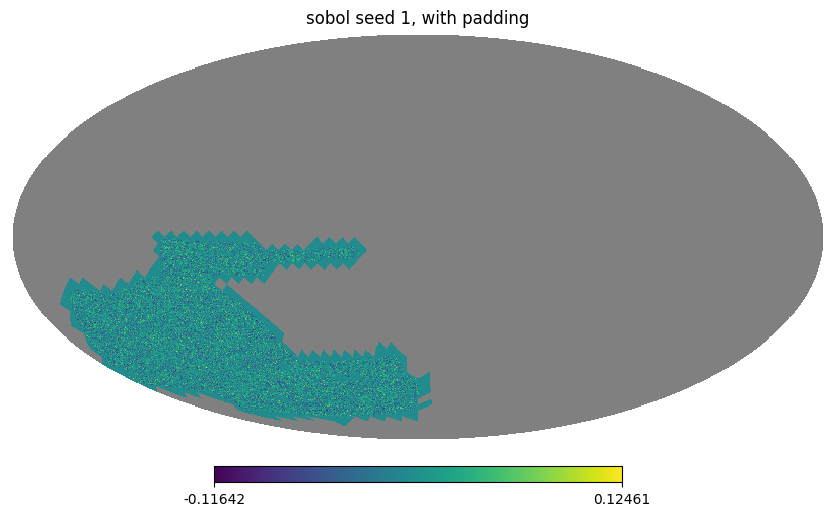

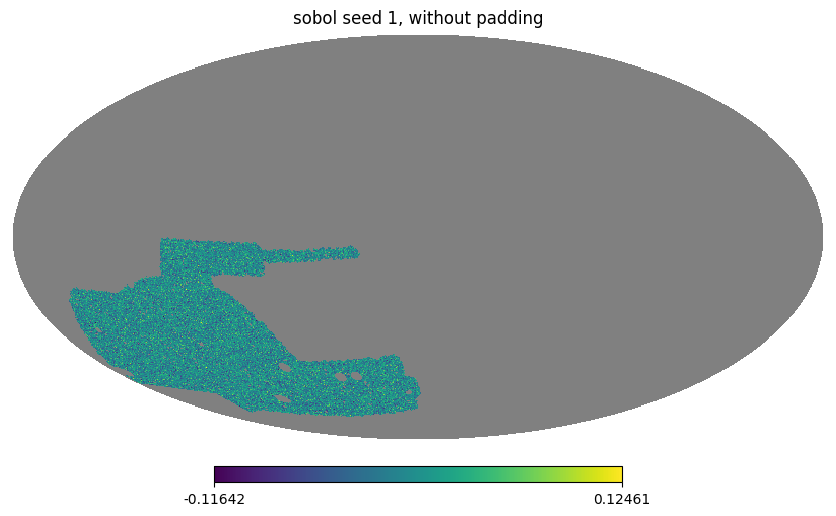

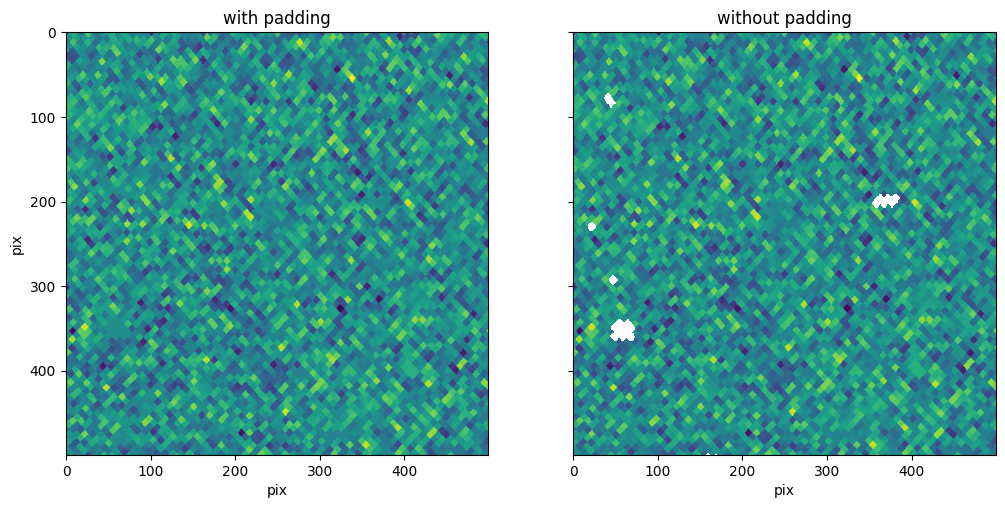

In [7]:
# map selection
i_tomo = 0
i_batch = 0

# gnomview params
square_pix = 500
reso = 1

for kg, cosmo, index in dset.take(1):
    # with padding
    padded_kg = kg.numpy()[i_batch,:,i_tomo]
    
    hp_map = np.full(n_pix, hp.UNSEEN)
    hp_map[data_vec_pix] = padded_kg
    hp.mollview(hp_map, nest=True, title=f"sobol seed {index[0][i_batch]}, with padding")
    padded_gnom = hp.gnomview(hp_map, nest=True, rot=(90, -30, 0), reso=reso, return_projected_map=True, no_plot=True, xsize=square_pix, ysize=square_pix)
    
    # without padding
    hp_map = maps.data_vec_to_map(padded_kg, n_pix, tomo_corresponding_pix[i_tomo], tomo_patches_pix[i_tomo][0])
    
    hp_map[hp_map == 0] = hp.UNSEEN
    hp.mollview(hp_map, nest=False, title=f"sobol seed {index[0][i_batch]}, without padding")
    non_padded_gnom = hp.gnomview(hp_map, nest=False, rot=(90, -30, 0), reso=reso, return_projected_map=True, no_plot=True, xsize=square_pix, ysize=square_pix)

    # combined gnomview plot, these should be identical apart from the padding
    fig, ax = plt.subplots(figsize=(12,8), ncols=2, sharex=True, sharey=True)
    ax[0].imshow(padded_gnom)
    ax[0].set(title="with padding", xlabel='pix', ylabel='pix')
    ax[1].imshow(non_padded_gnom)
    ax[1].set(title="without padding", xlabel='pix')
    
    